In [83]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import ForwardDiff as FD
import Convex as cvx 
import ECOS
import Plots

using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using StaticArrays
using Printf

plotlyjs()

  Activating project at `~/Desktop/Work/Courses/OCRL-Walker-Project/hybrid_traj_opt_5link`


Plots.PlotlyJSBackend()

In [84]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","walker.jl"))
include("DynamicSystems/biped5link.jl")
include("DynamicSystems/constraints.jl")
include("DynamicSystems/animate_walker.jl")

animate_walker (generic function with 3 methods)

We are setting up this problem by scheduling out the contact sequence. To do this, we will define the following sets:

$$ \begin{align} 
\mathcal{M}_1 &= \{1\text{:}5,11\text{:}15,21\text{:}25,31\text{:}35,41\text{:}45\} \\
\mathcal{M}_2 &= \{6\text{:}10,16\text{:}20,26\text{:}30,36\text{:}40\}
\end{align}$$

where $\mathcal{M}_1$ contains the time steps when foot 1 is pinned to the ground (`stance1_dynamics`), and $\mathcal{M}_2$ contains the time steps when foot 2 is pinned to the ground (`stance2_dynamics`). The jump map sets $\mathcal{J}_1$ and $\mathcal{J}_2$ are the indices where the mode of the next time step is different than the current, i.e. $\mathcal{J}_i \equiv \{k+1 \notin \mathcal{M}_i \; | \; k \in \mathcal{M}_i\}$. We can write these out explicitly as the following:

$$ \begin{align} 
\mathcal{J}_1 &= \{5,15,25,35\} \\
\mathcal{J}_2 &= \{10,20,30,40\}
\end{align}$$

Another term you will see is set subtraction, or $\mathcal{M}_i \setminus \mathcal{J}_i$. This just means that if  $k \in \mathcal{M}_i \setminus \mathcal{J}_i$, then $k$ is in $\mathcal{M}_i$ but not in $\mathcal{J}_i$. 

We will make use of the following Julia code for determining which set an index belongs to:

We are now going to setup and solve a constrained nonlinear program.  The optimization problem looks complicated but each piece should make sense and be relatively straightforward to implement. First we have the following LQR cost function that will track $x_{ref}$ (`Xref`) and $u_{ref}$ (`Uref`):

$$  J(x_{1:N},u_{1:N-1}) = \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{ref,i})^TQ(x_i - x_{ref,i}) + \frac{1}{2} (u_i-u_{ref,i})^TR(u_i-u_{ref,i}) \bigg] + \frac{1}{2}(x_N - x_{ref,N})^TQ_f(x_N - x_{ref,N})$$

Which goes into the following full optimization problem:
   $$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & J(x_{1:N},u_{1:N-1}) & \\ 
 \text{st} \quad &  x_1 = x_{ic} & \tag{1}\\
 \quad & x_N = x_{g} &\tag{2}\\
 &  x_{k+1} = f_1(x_k,u_k)  &\text{for } k \in  \mathcal{M}_1 \setminus \mathcal{J}_1 \tag{3}\\ 
 &  x_{k+1} = f_2(x_k,u_k)  &\text{for } k \in  \mathcal{M}_2 \setminus \mathcal{J}_2 \tag{4}\\ 
  &  x_{k+1} = g_2(f_1(x_k,u_k))  &\text{for } k \in   \mathcal{J}_1 \tag{5}\\ 
 &  x_{k+1} = g_1(f_2(x_k,u_k))  &\text{for } k \in   \mathcal{J}_2 \tag{6}\\ 
 &  x_{k}[4] = 0  &\text{for } k \in   \mathcal{M}_1 \tag{7}\\ 
 &  x_{k}[6] = 0  &\text{for } k \in   \mathcal{M}_2  \tag{8}\\ 
 &  0.5 \leq \| r^{(b)}_k - r^{(1)}_k\|_2 \leq 1.5 & \text{for } k \in [1, N]\tag{9} \\
  &  0.5 \leq \| r^{(b)}_k - r^{(2)}_k\|_2 \leq 1.5 & \text{for } k \in [1, N]\tag{10} \\
 &  x_{k}[2,4,6] \geq 0 & \text{for } k \in [1, N]\tag{11}
 \end{align}$$
 
 Each constraint is now described, with the type of constraint for `fmincon` in parantheses:
 1. Initial condition constraint **(equality constraint)**. 
 2. Terminal condition constraint **(equality constraint)**. 
 3. Stance 1 discrete dynamics **(equality constraint)**. 
 4. Stance 2 discrete dynamics **(equality constraint)**. 
 5. Discrete dynamics from stance 1 to stance 2 with jump 2 map **(equality constraint)**. 
 6. Discrete dynamics from stance 2 to stance 1 with jump 1 map **(equality constraint)**. 
 7. Make sure the foot 1 is pinned to the ground in stance 1 **(equality constraint)**.
 8. Make sure the foot 2 is pinned to the ground in stance 2 **(equality constraint)**.
 9. Length constraints between main body and foot 1 **(inequality constraint)**.
 10. Length constraints between main body and foot 2 **(inequality constraint)**.
 11. Keep the y position of all 3 bodies above ground **(primal bound)**.

And here we have the list of mathematical functions to the Julia function names:
- $f_1$ is `stance1_dynamics` + `rk4`
- $f_2$ is `stance2_dynamics` + `rk4`
- $g_1$ is `jump1_map`
- $g_2$ is `jump2_map`

For instance, $g_2(f_1(x_k,u_k))$ is `jump2_map(rk4(model, stance1_dynamics, xk, uk, dt))`

Remember that $r^{(b)}$ is defined above.

To solve this problem with Ipopt and `fmincon`, we are going to concatenate all of our $x$'s and $u$'s into one vector (same as HW3Q1):

$$ Z = \begin{bmatrix}x_1 \\ u_1 \\ x_2 \\ u_2 \\ \vdots \\ x_{N-1} \\ u_{N-1} \\ x_N \end{bmatrix} \in \mathbb{R}^{N \cdot nx + (N-1)\cdot nu} $$ 

where $x \in \mathbb{R}^{nx}$ and $u \in \mathbb{R}^{nu}$. Below we will provide useful indexing guide in `create_idx` to help you deal with $Z$.  Remember that the API for `fmincon` (that we used in HW3Q1) is the following:
$$ \begin{align} \min_{z} \quad & \ell(z) & \text{cost function}\\ 
 \text{st} \quad & c_{eq}(z) = 0 & \text{equality constraint}\\
 & c_L \leq c_{ineq}(z) \leq c_U & \text{inequality constraint}\\
 & z_L \leq z \leq z_U & \text{primal bound constraint}
 \end{align}$$
 
 Template code has been given to solve this problem but you should feel free to do whatever is easiest for you, as long as you get the trajectory shown in the animation `walker.gif` and pass tests. 

In [85]:
# feel free to solve this problem however you like, below is a template for a 
# good way to start. 

function create_idx(nx,nu,N)
    # create idx for indexing convenience
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    # and stacked dynamics constraints of size nx are 
    # c[idx.c[i]] = <dynamics constraint at time step i>
    #
    # feel free to use/not use this 
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx, nu=nu, N=N, nz=nz, nc=nc, x=x, u=u, c=c)
end

function walker_cost(params::NamedTuple, Z::Vector)::Real
    # cost function 
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    Xref,Uref = params.Xref, params.Uref
    
    # TODO: input walker LQR cost 
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += 0.5*(xi - Xref[i])'*Q*(xi - Xref[i])
        J += 0.5*(ui - Uref[i])'*R*(ui - Uref[i]) 
    end
    
    xn = Z[idx.x[N]]
    J += 0.5*(xn - xg)'*Qf*(xn - xg)
        
    return J 
end

function walker_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    M1, M2 = params.M1, params.M2 
    J1, J2 = params.J1, params.J2 
    model = params.model 
        
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    # TODO: input walker dynamics constraints (constraints 3-6 in the opti problem)
    for k = 1:(N-1)
        xk   = Z[idx.x[k]]
        uk   = Z[idx.u[k]]
        xkp1 = Z[idx.x[k+1]]
        
        # if (k in M1) # (not in J1) is implied 
        #     c[idx.c[k]] = discrete_stance1_dynamics(model, xk, uk, dt) - xkp1 
        # elseif (k in M2) # (not in J1) is implied 
        #     c[idx.c[k]] = discrete_stance2_dynamics(model, xk, uk, dt) - xkp1 
        # end

        if (k in J1)
            c[idx.c[k]] = discrete_unconstrained_dynamics(model, xk, uk, dt) - xkp1
        elseif (k in J2)
            c[idx.c[k]] = discrete_unconstrained_dynamics(model, xk, uk, dt) - xkp1
        elseif (k in M1) # (not in J1) is implied 
            c[idx.c[k]] = discrete_stance1_dynamics(model, xk, uk, dt) - xkp1 
        elseif (k in M2) # (not in J1) is implied 
            c[idx.c[k]] = discrete_stance2_dynamics(model, xk, uk, dt) - xkp1 
        end
    end

    return c 
end

function walker_stance_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    M1, M2 = params.M1, params.M2 
    J1, J2 = params.J1, params.J2 
    
    model = params.model 

    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), N)
    
    # TODO: add walker stance constraints (constraints 7-8 in the opti problem)
    for k = 1:N 
        x = Z[idx.x[k]]
        q = x[1:7]
        r = biped5link_kinematics(q, model)
        if (k in M1)
            c[k] = r[1,2]
        elseif (k in M2)
            c[k] = r[5,2]
        end
    end

    return c
end
    
function walker_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    # TODO: stack up all of our equality constraints 
    
    # should be length 2*nx + (N-1)*nx + N 
    # inital condition constraint (nx)       (constraint 1)
    # terminal constraint         (nx)       (constraint 2)
    # dynamics constraints        (N-1)*nx   (constraint 3-6)
    # stance constraint           N          (constraint 7-8)
    [   
      Z[idx.x[1]] - xic;
      Z[idx.x[N]] - xg;
      # walker_dynamics_constraints(params, Z);
      # walker_stance_constraint(params, Z)
    ]
end

function walker_inequality_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    M1, M2 = params.M1, params.M2 
        
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), 6*N)
    
    # TODO: add the length constraints shown in constraints (9-10)
    # there are 2*N constraints here 
    
    iter = 1 
    for k = 1:6:6*N
        xk = Z[idx.x[Int((k+5)/6)]]
        r = biped5link_kinematics(xk[1:7], params.model)
        r2y = r[2,2]
        r3y = r[3,2]
        r4y = r[4,2]
        r6y = r[6,2]
        c[k:k+3] = vcat([r2y; r3y; r4y; r6y]...)
        c[k+4] = xk[3] - xk[4]
        c[k+5] = xk[7] - xk[6]
    end
    return c
end

walker_inequality_constraint (generic function with 1 method)

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    22568
Number of nonzeros in inequality constraint Jacobian.:   217620
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      806
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints.......

┌ Info: Saved animation to /home/sman/Desktop/Work/Courses/OCRL-Walker-Project/hybrid_traj_opt_5link/5_link_walker.gif
└ @ Plots /home/sman/.julia/packages/Plots/ju9dp/src/animation.jl:156


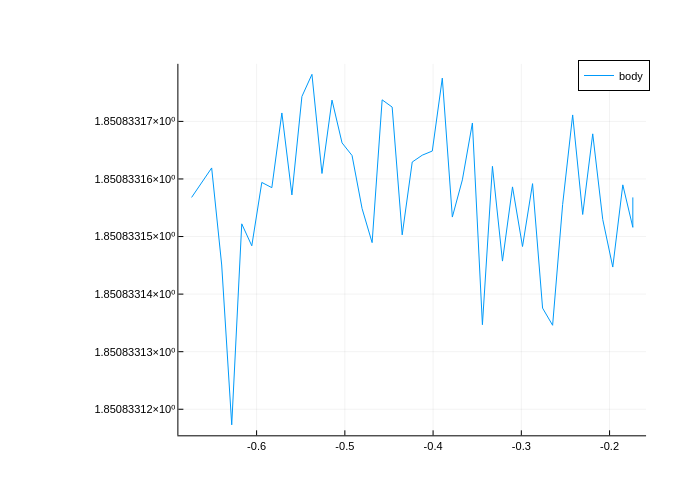

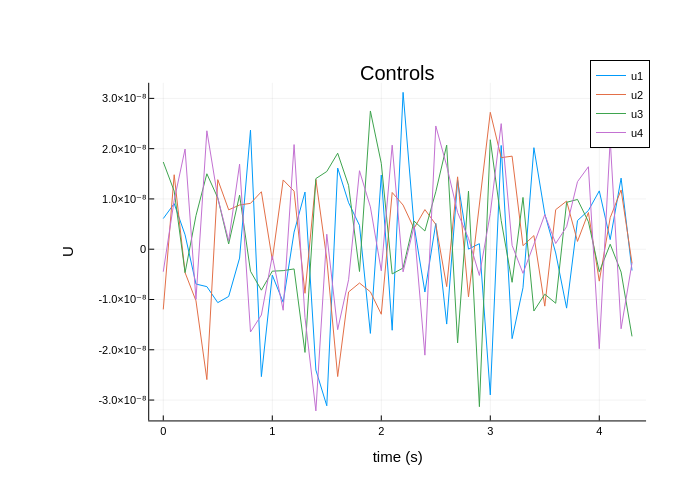

In [86]:
# dynamics parameters 
model = (m1 = 1,  m2 = 1,  m3 = 1,  m4 = 1,  m5 = 1,  m6 = 1,
            l12 = 1, l23 = 1, l34 = 1, l45 = 1, l36 = 1, g = 9.81)

# problem size 
nx = 14 
nu = 4 
tf = 4.4 
dt = 0.1
t_vec = 0:dt:tf 
N = length(t_vec)

# initial and goal states
# determine the fixed joint angles
theta_offset = 20 # determines, how spread out we want the legs

q1 = 280 * (π/180)
q2 = 300 * (π/180)
q3 = 90 * (π/180)
q4 = 250 * (π/180)
q5 = 220 * (π/180)

x0 = - model.l23 * cos(q2) - model.l12 * cos(q1)
y0 = - model.l23 * sin(q2) - model.l12 * sin(q1)

dx0 = dy0 = dq1 = dq2 = dq3 = dq4 = dq5 = 0

# #determine the fixed x and y positions

xic = [ x0;  y0;  q1;  q2;  q3;  q4;  q5; 
        dx0; dy0; dq1; dq2; dq3; dq4; dq5]
# dx = 5 # suppose our goal is to move like 5 meters forward
dx = 0.5 # suppose our goal is to move like 5 meters forward
xg = [x0 + dx;  y0;  q1;  q2;  q3;  q4;  q5; 
            dx0; dy0; dq1; dq2; dq3; dq4; dq5]

# index sets 
# M1 = vcat([ (i-1)*10      .+ (1:5)   for i = 1:5]...)
# M2 = vcat([((i-1)*10 + 5) .+ (1:5)   for i = 1:4]...)
# J1 = [5,15,25,35]
# J2 = [10,20,30,40]
M1 = [1:45]
M2 = [46]
J1 = [46]
J1 = [46] 

# reference trajectory 
Xref, Uref = reference_trajectory(model, xic, xg, dt, N, M1, tf)

# animate_walker(Xref, model)

# LQR cost function (tracking Xref, Uref)
# Q = diagm([1; 10; fill(1.0, 5); 1; 10; fill(1.0, 5)]);
# TODO: change this ↓ to maximize cg position along trajectory
Q = diagm(fill(1.0,14))
R = diagm(fill(1e-3,4))
Qf = 1*Q;

# create indexing utilities 
idx = create_idx(nx,nu,N)

# put everything useful in params 
params = (
    model = model, 
    nx = nx,
    nu = nu,
    tf = tf, 
    dt = dt, 
    t_vec = t_vec,
    N = N, 
    M1 = M1, 
    M2 = M2,
    J1 = J1, 
    J2 = J2,
    xic = xic, 
    xg = xg,
    idx = idx,
    Q = Q, R = R, Qf = Qf,
    Xref = Xref, 
    Uref = Uref
)

# TODO: primal bounds (constraint 11)
x_l = -Inf*ones(idx.nz)
x_u =  Inf*ones(idx.nz)

# for i = 1:N
#     x_l[idx.x[i][[2]]] .= 0 
# end

# TODO: inequality constraint bounds
c_l = -Inf*ones(6*N)
c_u = Inf*ones(6*N)

# TODO: initial guess, initialize z0 with the reference Xref, Uref 
z0 = zeros(idx.nz)

for i = 1:N 
    z0[idx.x[i]] = 1*Xref[i]
end
for i = 1:N-1 
    z0[idx.u[i]] = 1*Uref[i]
end

# adding a little noise to the initial guess is a good idea 
z0 = z0 + (1e-3)*randn(idx.nz)

diff_type = :auto 

Z = fmincon(walker_cost,walker_equality_constraint,walker_inequality_constraint,
            x_l,x_u,c_l,c_u,z0,params, diff_type;
            tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = true)

# pull the X and U solutions out of Z 
X = [Z[idx.x[i]] for i = 1:N]
U = [Z[idx.u[i]] for i = 1:(N-1)]

# ------------plotting--------------
Xm = hcat(X...)
Um = hcat(U...)


animate_walker(X, model)

display(plot(Xm[1,:],Xm[2,:], label = "body"))
display(plot(t_vec[1:end-1], Um',xlabel = "time (s)", ylabel = "U",
                label = ["u1" "u2" "u3" "u4"], title = "Controls"))